In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from contextlib import contextmanager
from time import time
from tqdm import tqdm
import lightgbm as lgbm
import category_encoders as ce

from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Target setting

In [2]:
data0=pd.read_csv('../input/shark-attack-dataset/attacks.csv')
data0

,Case Number,Date,Year,Type,Country,Area,Location,Activity,Name,Sex,...,Species,Investigator or Source,pdf,href formula,href,Case Number.1,Case Number.2,original order,Unnamed: 22,Unnamed: 23
0,2018.06.25,25-Jun-2018,2018.0,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,...,White shark,"R. Collier, GSAF",2018.06.25-Wolfe.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.25,2018.06.25,6303.0,NaN,NaN
1,2018.06.18,18-Jun-2018,2018.0,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson�McNeely,F,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.18-McNeely.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.18,2018.06.18,6302.0,NaN,NaN
2,2018.06.09,09-Jun-2018,2018.0,Invalid,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,...,NaN,"K.McMurray, TrackingSharks.com",2018.06.09-Denges.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.09,2018.06.09,6301.0,NaN,NaN
3,2018.06.08,08-Jun-2018,2018.0,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,...,2 m shark,"B. Myatt, GSAF",2018.06.08-Arrawarra.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.08,2018.06.08,6300.0,NaN,NaN
4,2018.06.04,04-Jun-2018,2018.0,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,...,"Tiger shark, 3m",A .Kipper,2018.06.04-Ramos.pdf,http://sharkattackfile.net/spreadsheets/pdf_di...,http://sharkattackfile.net/spreadsheets/pdf_di...,2018.06.04,2018.06.04,6299.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25718,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
print(data0.columns.tolist())

['Case Number', 'Date', 'Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time', 'Species ', 'Investigator or Source', 'pdf', 'href formula', 'href', 'Case Number.1', 'Case Number.2', 'original order', 'Unnamed: 22', 'Unnamed: 23']


In [4]:
data1=data0.loc[0:6301]
data1=data1.drop(['Unnamed: 22', 'Unnamed: 23'],axis=1)
data2=data1[['Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time', 'Species ', ]]
data2[0:2].T

,0,1
Year,2018.0,2018.0
Type,Boating,Unprovoked
Country,USA,USA
Area,California,Georgia
Location,"Oceanside, San Diego County","St. Simon Island, Glynn County"
Activity,Paddling,Standing
Name,Julie Wolfe,Adyson�McNeely
Sex,F,F
Age,57,11
Injury,"No injury to occupant, outrigger canoe and pad...",Minor injury to left thigh


In [5]:
data2=data2.fillna('NaN')
data2[0:2].T

,0,1
Year,2018.0,2018.0
Type,Boating,Unprovoked
Country,USA,USA
Area,California,Georgia
Location,"Oceanside, San Diego County","St. Simon Island, Glynn County"
Activity,Paddling,Standing
Name,Julie Wolfe,Adyson�McNeely
Sex,F,F
Age,57,11
Injury,"No injury to occupant, outrigger canoe and pad...",Minor injury to left thigh


In [6]:
print(data2.columns.tolist())

['Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Fatal (Y/N)', 'Time', 'Species ']


In [7]:
year=[]
for item in data2['Year']:
    if item=='NaN':
        year+=['NaN']
    elif item<1000:
        year+=['NaN']
    else:
        year+=[int(item)]
data2['Year']=year

In [8]:
Name1=list(data2['Type'].unique())
print(Name1)
Name2=['Boating', 'Unprovoked', 'NaN', 'Provoked','NaN','Sea Disaster', 'NaN', 'Boating', 'Boating']
normal_mapping=dict(zip(Name1,Name2)) 

['Boating', 'Unprovoked', 'Invalid', 'Provoked', 'Questionable', 'Sea Disaster', 'NaN', 'Boat', 'Boatomg']


In [9]:
data2['Type']=data2['Type'].map(normal_mapping)

In [10]:
Name1a=list(data2['Fatal (Y/N)'].unique())
print(Name1a)
Name2a=['N', 'Y', 'NaN', 'NaN', 'NaN', 'NaN', 'N', 'N', 'Y']
normal_mapping_a=dict(zip(Name1a,Name2a)) 

['N', 'Y', 'NaN', 'M', 'UNKNOWN', '2017', ' N', 'N ', 'y']


In [11]:
data2['Fatal (Y/N)']=data2['Fatal (Y/N)'].map(normal_mapping_a)

In [12]:
drop_index=data2[data2['Fatal (Y/N)']=='NaN'].index.tolist()
print(len(drop_index))
print(drop_index)
data2=data2.drop(index=data2.index[drop_index]).reset_index(drop=True)
data2

612
[27, 76, 79, 84, 98, 107, 115, 124, 125, 145, 151, 153, 159, 187, 189, 195, 206, 226, 265, 269, 285, 289, 291, 294, 297, 306, 307, 334, 344, 373, 378, 382, 384, 391, 392, 402, 437, 438, 456, 459, 466, 499, 507, 525, 532, 558, 570, 576, 578, 624, 633, 657, 660, 676, 688, 690, 708, 721, 732, 761, 763, 764, 768, 771, 778, 786, 814, 830, 836, 839, 859, 874, 882, 890, 926, 940, 953, 967, 994, 1003, 1044, 1064, 1069, 1093, 1107, 1117, 1118, 1136, 1138, 1162, 1167, 1178, 1212, 1217, 1219, 1235, 1240, 1270, 1271, 1272, 1273, 1292, 1295, 1301, 1304, 1314, 1326, 1361, 1366, 1371, 1381, 1401, 1407, 1410, 1427, 1433, 1441, 1442, 1456, 1458, 1485, 1495, 1499, 1511, 1547, 1557, 1560, 1563, 1566, 1567, 1569, 1577, 1581, 1597, 1600, 1606, 1618, 1628, 1639, 1661, 1670, 1682, 1696, 1701, 1707, 1711, 1729, 1744, 1751, 1771, 1799, 1805, 1848, 1866, 1879, 1893, 1941, 1947, 1971, 1975, 1989, 1991, 2025, 2026, 2055, 2068, 2083, 2141, 2144, 2168, 2201, 2212, 2216, 2230, 2250, 2260, 2267, 2285, 2295, 2307,

,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
0,2018,Boating,USA,California,"Oceanside, San Diego County",Paddling,Julie Wolfe,F,57,"No injury to occupant, outrigger canoe and pad...",N,18h00,White shark
1,2018,Unprovoked,USA,Georgia,"St. Simon Island, Glynn County",Standing,Adyson�McNeely,F,11,Minor injury to left thigh,N,14h00 -15h00,NaN
2,2018,NaN,USA,Hawaii,"Habush, Oahu",Surfing,John Denges,M,48,Injury to left lower leg from surfboard skeg,N,07h45,NaN
3,2018,Unprovoked,AUSTRALIA,New South Wales,Arrawarra Headland,Surfing,male,M,NaN,Minor injury to lower leg,N,NaN,2 m shark
4,2018,Provoked,MEXICO,Colima,La Ticla,Free diving,Gustavo Ramos,M,NaN,Lacerations to leg & hand shark PROVOKED INCIDENT,N,NaN,"Tiger shark, 3m"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5685,NaN,Unprovoked,AUSTRALIA,Western Australia,Roebuck Bay,Diving,male,M,NaN,FATAL,Y,NaN,NaN
5686,NaN,Unprovoked,AUSTRALIA,Western Australia,NaN,Pearl diving,Ahmun,M,NaN,FATAL,Y,NaN,NaN
5687,NaN,Unprovoked,USA,North Carolina,Ocracoke Inlet,Swimming,Coast Guard personnel,M,NaN,FATAL,Y,NaN,NaN
5688,NaN,Unprovoked,PANAMA,NaN,"Panama Bay 8�N, 79�W",NaN,Jules Patterson,M,NaN,FATAL,Y,NaN,NaN


In [13]:
list_cols = ['Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 'Sex ', 
             'Age', 'Injury', 'Fatal (Y/N)', 'Time', 'Species ']
ce_ohe = ce.OrdinalEncoder(cols=list_cols,handle_unknown='impute')
data3 = ce_ohe.fit_transform(data2)
data3

/opt/conda/lib/python3.7/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,Year,Type,Country,Area,Location,Activity,Name,Sex,Age,Injury,Fatal (Y/N),Time,Species
0,1,1,1,1,1,1,1,1,1,1,1,1,1
1,1,2,1,2,2,2,2,1,2,2,1,2,2
2,1,3,1,3,3,3,3,2,3,3,1,3,2
3,1,2,2,4,4,3,4,2,4,4,1,4,3
4,1,4,3,5,5,4,5,2,4,5,1,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5685,180,2,2,15,3758,23,4,2,4,7,2,4,2
5686,180,2,2,15,54,908,4793,2,4,7,2,4,2
5687,180,2,1,67,3759,6,4301,2,4,7,2,4,2
5688,180,2,67,20,3760,22,4794,2,4,7,2,4,2


In [14]:
target=['Fatal (Y/N)']
datay=data3['Fatal (Y/N)']
datax=data3.drop('Fatal (Y/N)',axis=1)

In [15]:
print(datay[0:2].T)
print()
print(datax[0:2].T)

0    1
1    1
Name: Fatal (Y/N), dtype: int64

          0  1
Year      1  1
Type      1  2
Country   1  1
Area      1  2
Location  1  2
Activity  1  2
Name      1  2
Sex       1  1
Age       1  2
Injury    1  2
Time      1  2
Species   1  2


In [16]:
n=len(data3)
print(n)

5690


In [17]:
N=[]
for i in range(n):
    N+=[i]
random.shuffle(N)

In [18]:
trainX=datax.loc[N[0:(n//4)*3]]
trainY=datay.loc[N[0:(n//4)*3]]
testX=datax.loc[N[(n//4)*3:]]
testY=datay.loc[N[(n//4)*3:]]

In [19]:
print(trainX.shape)
print(testX.shape)

(4266, 12)
(1424, 12)


In [20]:
df_columns = list(datax.columns)
print(df_columns)

['Year', 'Type', 'Country', 'Area', 'Location', 'Activity', 'Name', 'Sex ', 'Age', 'Injury', 'Time', 'Species ']


In [21]:
train_df=trainX
test_df=testX

In [22]:
train_df.columns=df_columns
test_df.columns=df_columns

In [23]:
def create_numeric_feature(input_df):
    use_columns = df_columns 
    return input_df[use_columns].copy()

In [24]:
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [25]:
from tqdm import tqdm

def to_feature(input_df):

    processors = [
        create_numeric_feature,
    ]
    
    out_df = pd.DataFrame()
    
    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='create' + func.__name__ + ' '):
            _df = func(input_df)

        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
        
    return out_df

In [26]:
train_feat_df = to_feature(train_df)
test_feat_df = to_feature(test_df)

100%|██████████| 1/1 [00:00<00:00, 637.04it/s]

createcreate_numeric_feature  0.001[s]
createcreate_numeric_feature  0.001[s]


# Model

In [27]:
import lightgbm as lgbm
from sklearn.metrics import mean_squared_error

def fit_lgbm(X, y, cv, 
             params: dict=None, 
             verbose: int=50):

    if params is None:
        params = {}

    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)
        
        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')
        print()

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [28]:
params = {
    'objective': 'rmse', 
    'learning_rate': .1,
    'reg_lambda': 1.,
    'reg_alpha': .1,
    'max_depth': 5, 
    'n_estimators': 10000, 
    'colsample_bytree': .5, 
    'min_child_samples': 10,
    'subsample_freq': 3,
    'subsample': .9,
    'importance_type': 'gain', 
    'random_state': 71,
    'num_leaves': 62
}

In [29]:
y = trainY
print(y.shape)
ydf=pd.DataFrame(y)
ydf

(4266,)


,Fatal (Y/N)
5418,2
4291,1
3696,2
5601,2
357,1
...,...
5068,2
1647,1
950,1
573,1


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 0.243433
fit fold=0  0.177[s]
Fold 0 RMSLE: 0.2434

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 0.272547
fit fold=1  0.154[s]
Fold 1 RMSLE: 0.2725

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 0.256524
fit fold=2  0.155[s]
Fold 2 RMSLE: 0.2565

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's rmse: 0.25459
fit fold=3  0.166[s]
Fold 3 RMSLE: 0.2546

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 0.249538
fit fold=4  0.134[s]
Fold 4 RMSLE: 0.2495

--------------------------------------------------
FINISHED | Whole RMSLE: 0.2555


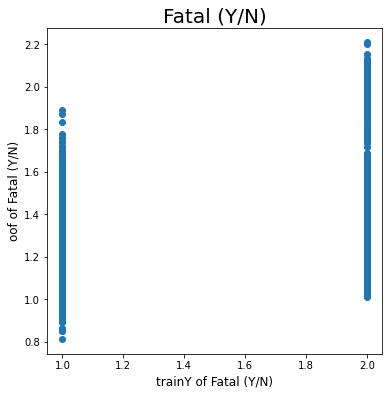

In [30]:
from sklearn.model_selection import KFold

for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    
    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_title(target[i],fontsize=20)
    ax.set_xlabel('trainY of '+target[i],fontsize=12)
    ax.set_ylabel('oof of '+target[i],fontsize=12)
    ax.scatter(y,oof)

In [31]:
print(target)

['Fatal (Y/N)']


# Visualize Importance and Predict

In [32]:
def visualize_importance(models, feat_train_df):

    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    
    ax.tick_params(axis='x', rotation=0)
    #ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig,ax

#fig, ax = visualize_importance(models, train_feat_df)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[62]	valid_0's rmse: 0.243433
fit fold=0  0.139[s]
Fold 0 RMSLE: 0.2434

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[91]	valid_0's rmse: 0.272547
fit fold=1  0.156[s]
Fold 1 RMSLE: 0.2725

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 0.256524
fit fold=2  0.131[s]
Fold 2 RMSLE: 0.2565

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's rmse: 0.25459
fit fold=3  0.164[s]
Fold 3 RMSLE: 0.2546

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[60]	valid_0's rmse: 0.249538
fit fold=4  0.131[s]
Fold 4 RMSLE: 0.2495

--------------------------------------------------
FINISHED | Whole RMSLE: 0.2555


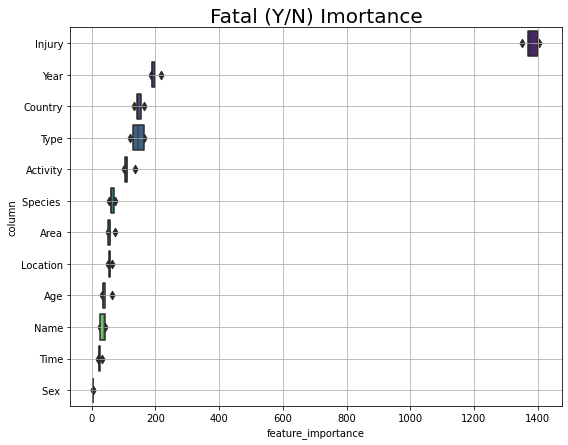

In [33]:
pred1=[]
for i in range(1):
    fold = KFold(n_splits=5, shuffle=True, random_state=71)
    ydfi=ydf.iloc[:,i]
    y=np.array(ydfi)
    cv = list(fold.split(train_feat_df, y))
    oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)
    fig, ax = visualize_importance(models, train_feat_df)
    ax.set_title(target[i]+' Imortance',fontsize=20)
    pred0 = np.array([model.predict(test_feat_df.values) for model in models])
    pred1+=[np.mean(pred0, axis=0)]

## For fatality('Fatal (Y/N)'), 'Injury' is the most important factor.

In [34]:
data2[data2['Fatal (Y/N)']=='Y']['Injury'].unique()[0:100]

array(['FATAL', 'Fatal',
       'FATAL, arm bitten by shark hauled on deck             PROVOKED INCIDENT',
       'Thigh bitten, FATAL',
       'Cause of death was drowning; his remains were scavenged by sharks',
       'It is probable that all 5 passengers died on impact. The body of one was scavenged by a shark',
       'Torso & righ arm bitten FATAL',
       'FATAL    Severe bite to right thigh', 'Leg bitten, FATAL',
       'FATAL        Only 4 of the 18 on board were rescued, some of the missing were allegedly killed by sharks',
       'Some of the bodies recovered had been bitten by sharks',
       'FATAL,  beaten & thrown overboard by smugglers, they  were killed by sharks',
       'Presumed FATAL, body not recovered',
       '15 perished but shark involvement prior to death was not confirmed',
       'Left thigh bitten FATAL', 'Reportedly FATAL but few details',
       'Severe bite to right leg FATAL', 'FATAL PROVOKED INCIDENT',
       'FATAL, leg bitten', 'FATAL, abdomen, pelvi

In [35]:
df = data2[data2['Fatal (Y/N)']=='Y']['Injury']

In [36]:
import re
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
nltk.download('wordnet')
import nltk as nlp

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [37]:
cult_list=[]

for cult in df:
    cult=re.sub("[^a-zA-z]"," ",cult)
    cult=cult.lower()
    cult=nltk.word_tokenize(cult)
    lemma=nlp.WordNetLemmatizer()
    cult=[lemma.lemmatize(word) for word in cult]
    cult=" ".join(cult)
    cult_list.append(cult)

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
max_features=200
count_vectorizer=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=count_vectorizer.fit_transform(cult_list).toarray()

In [39]:
data3 = pd.DataFrame(count_vectorizer.get_feature_names(),columns=["Words"])
data3

,Words
0,abdomen
1,abdominal
2,air
3,aircraft
4,amputated
...,...
195,womack
196,woman
197,wound
198,wrist


In [40]:
random.seed(2019)
random.shuffle(data3.Words)
data3[0:10]

,Words
0,hauled
1,killed
2,femoral
3,hip
4,provoked
5,second
6,injury
7,fought
8,severe
9,sailor


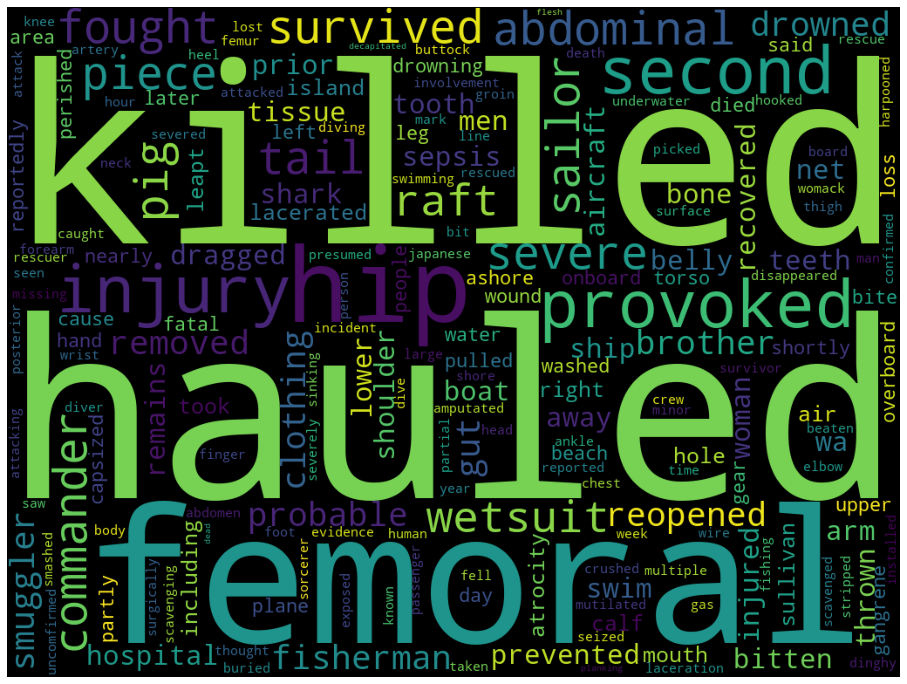

In [41]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

plt.subplots(figsize=(16,16))
wordcloud=WordCloud(background_color="black",width=1024,height=768).generate(" ".join(data3.Words))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()